In [17]:
from pathlib import Path
from IPython.display import HTML, display
import os
import base64
import shutil
from PIL import Image
import numpy as np

Tests in archive: 87 (521 questions)
Tests left: 58


Q,question.png,answer.png
Q1,,
Q2,,
Q3,,
Q4,,
Q5,,
Q6,,

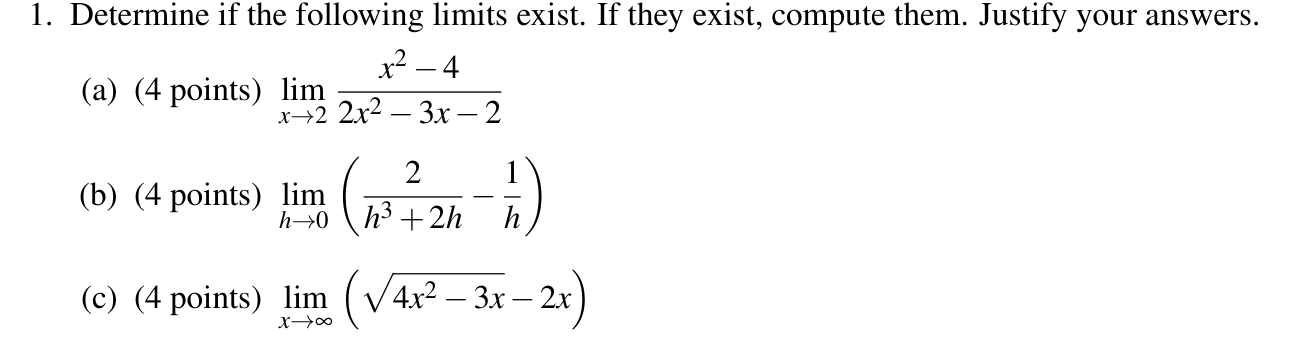
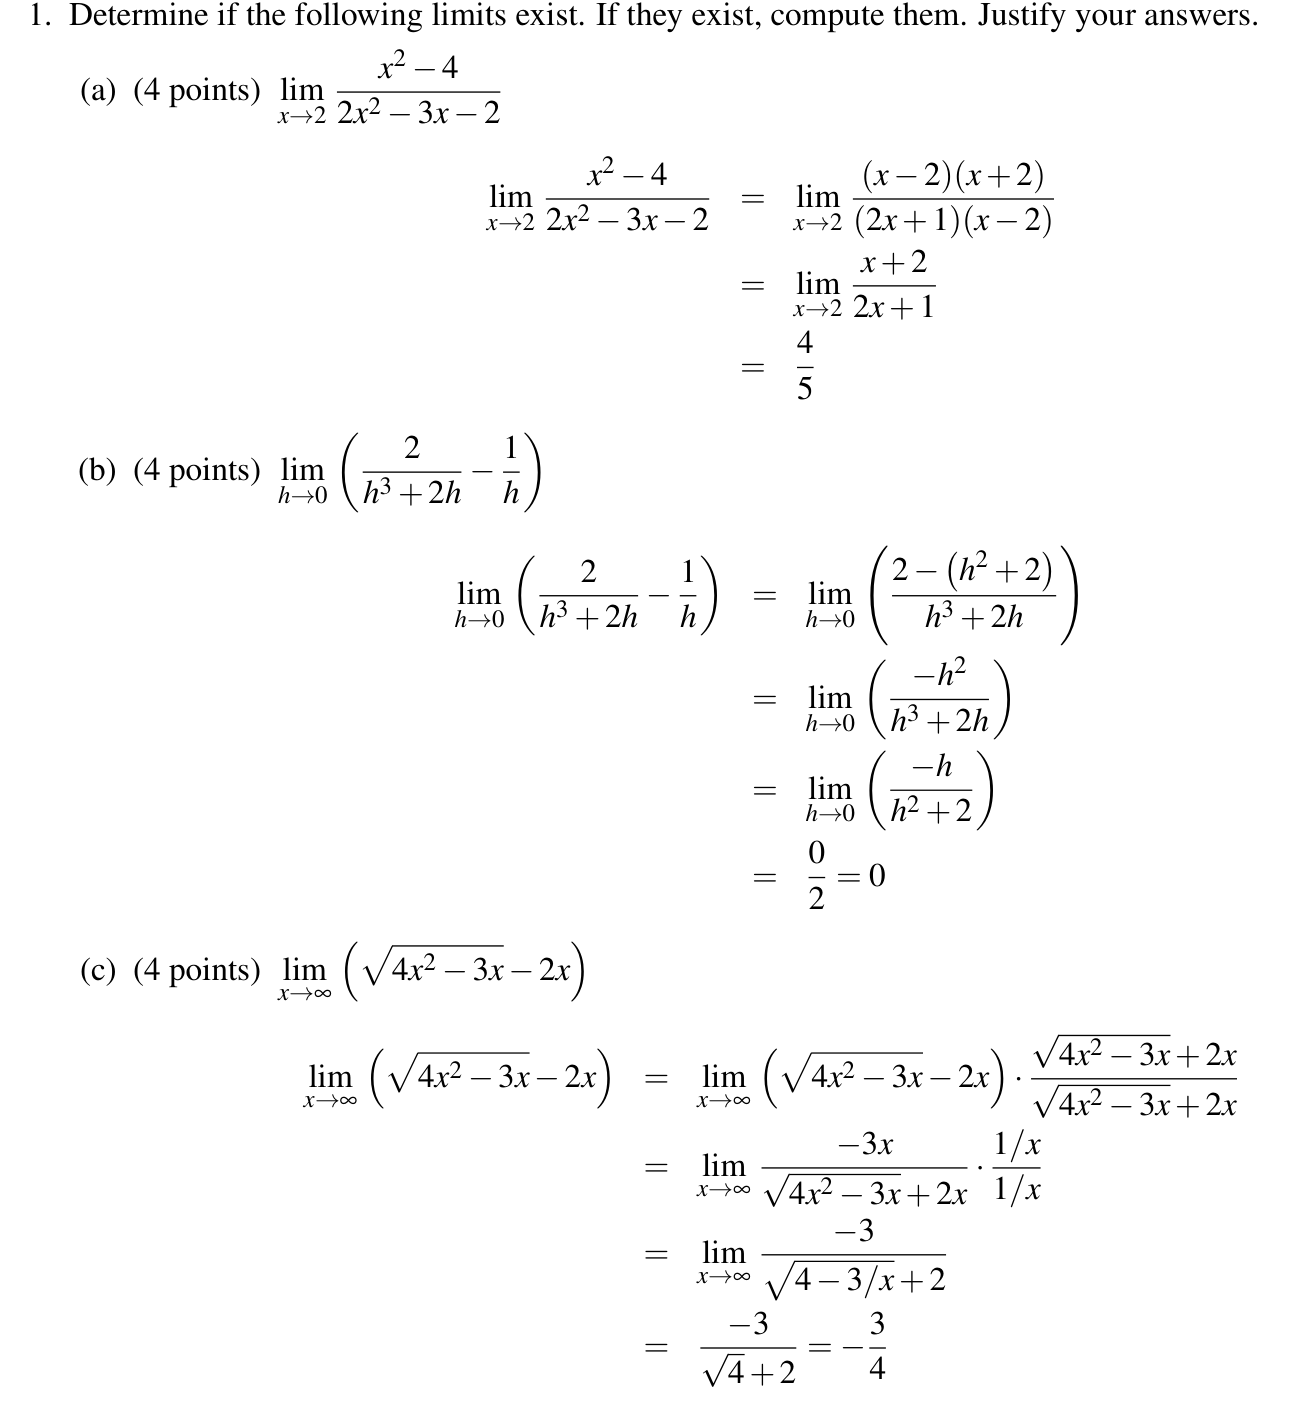
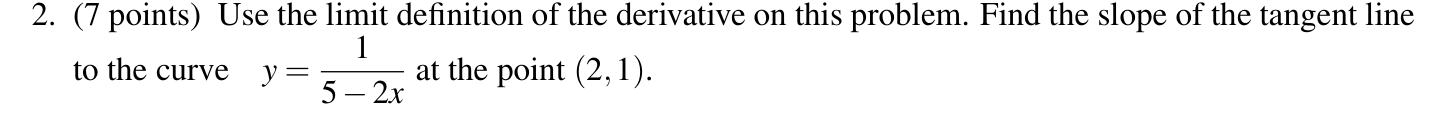
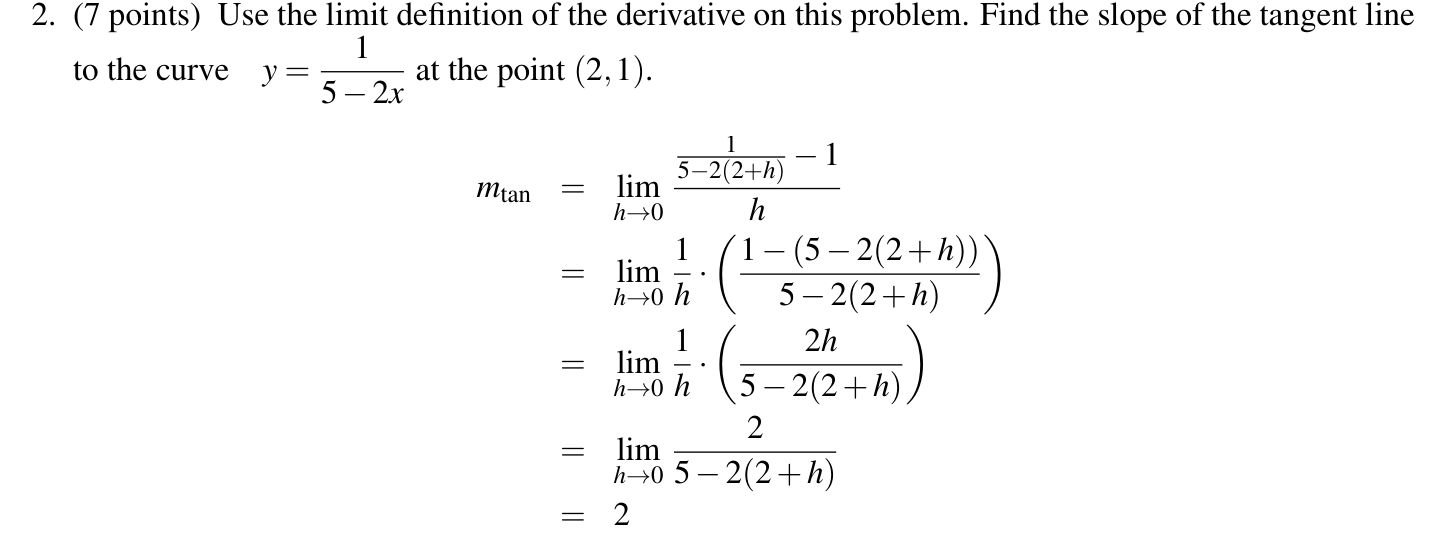
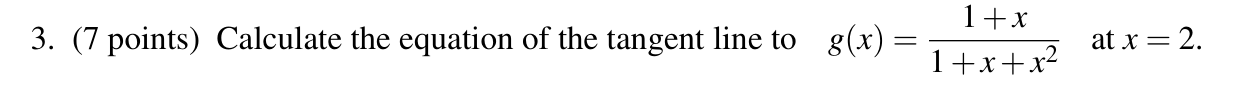
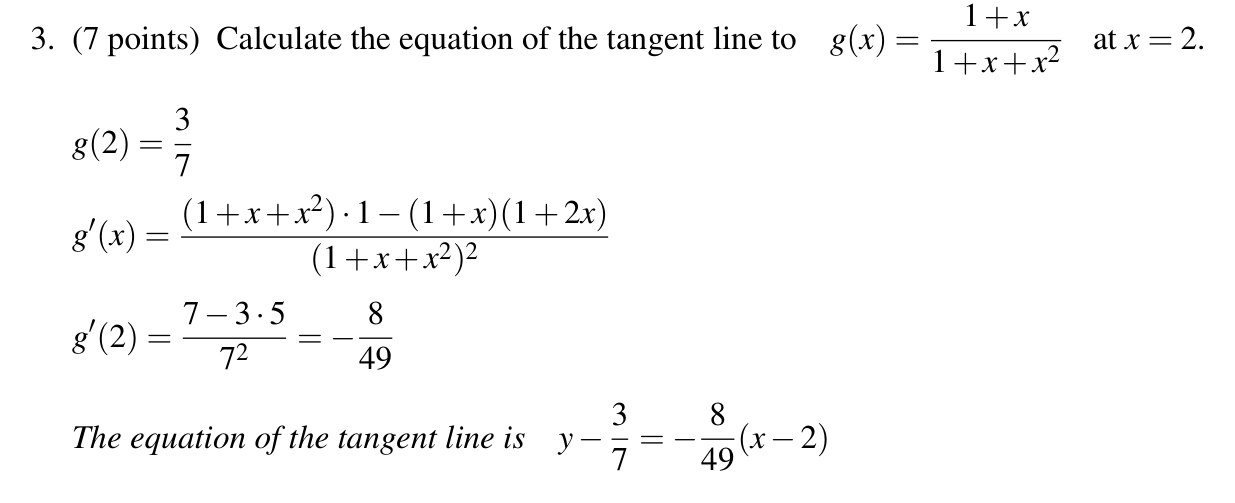
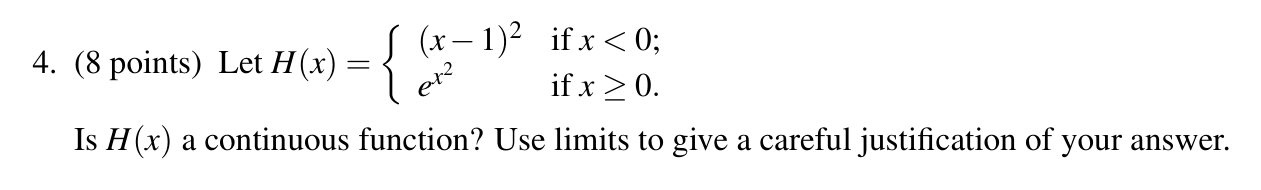
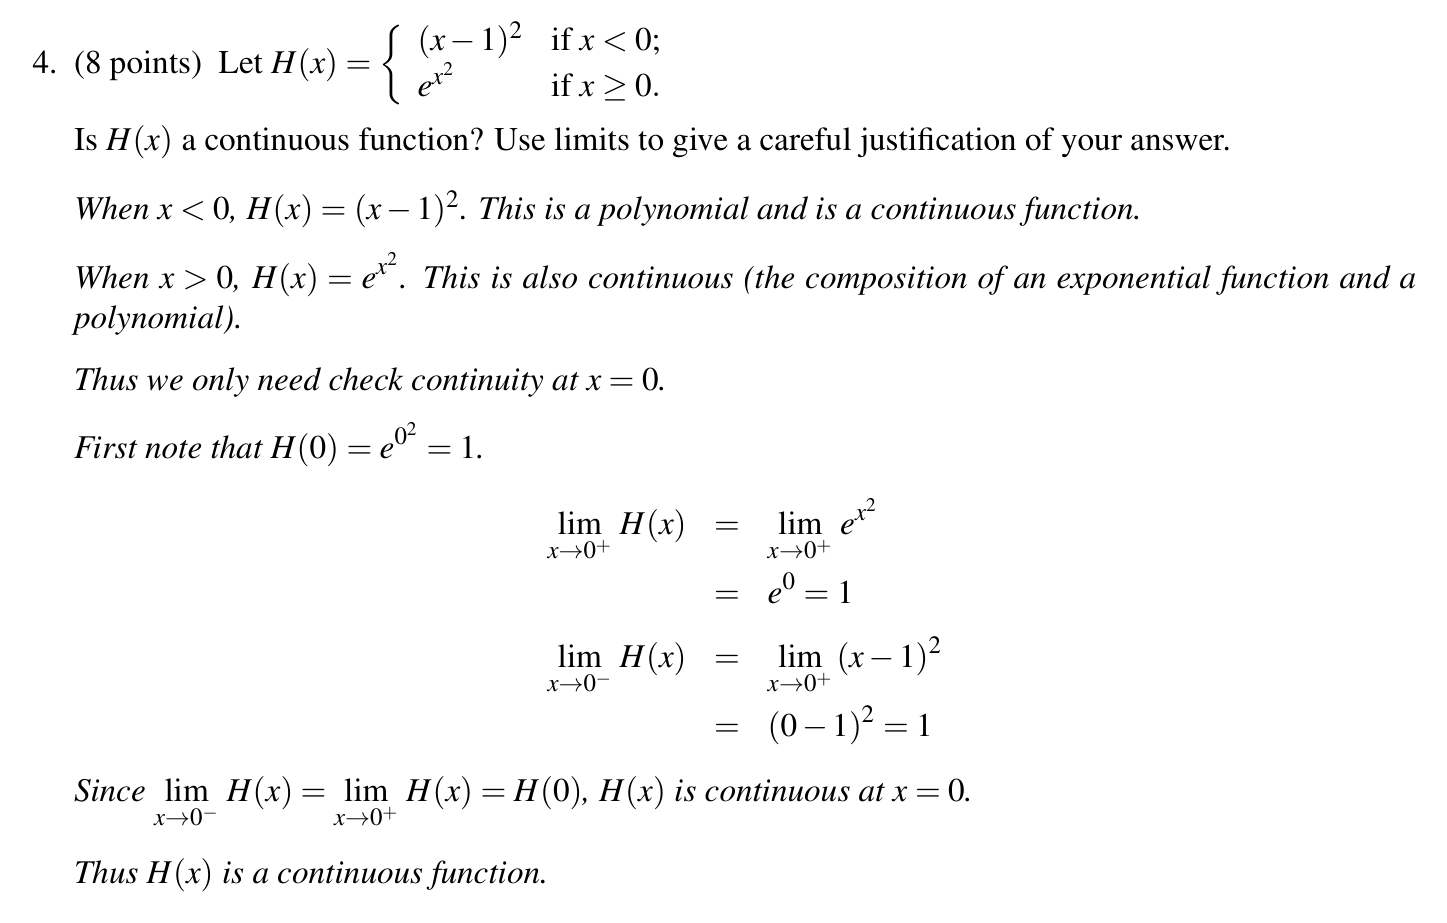
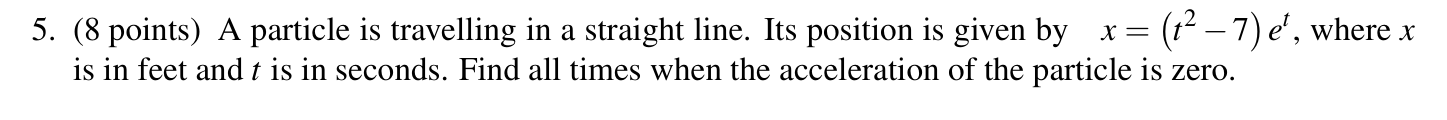
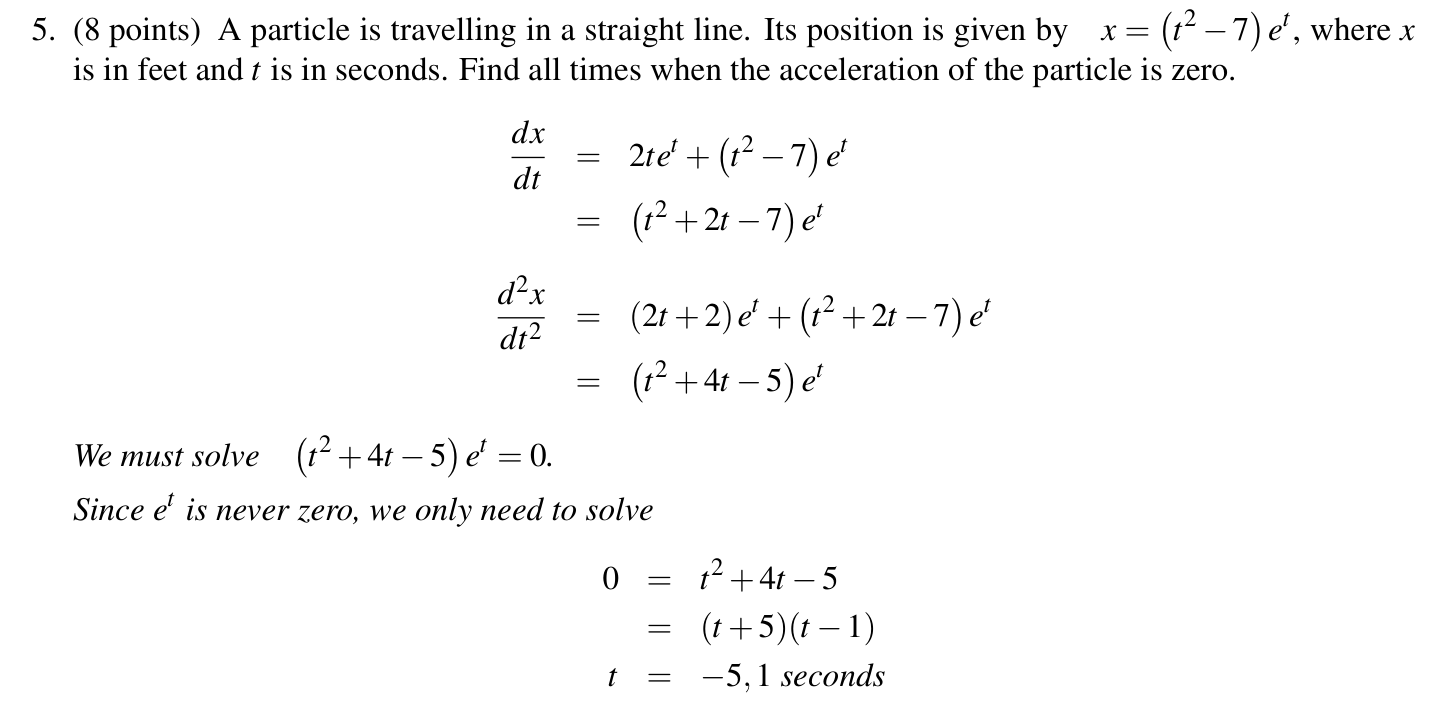
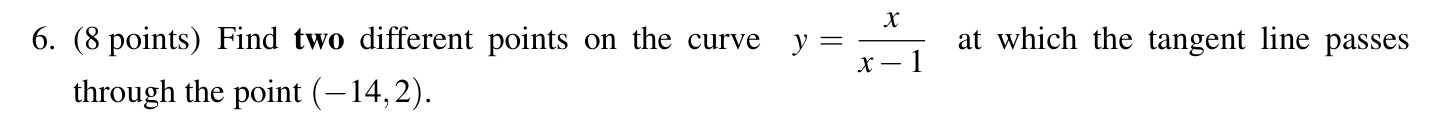
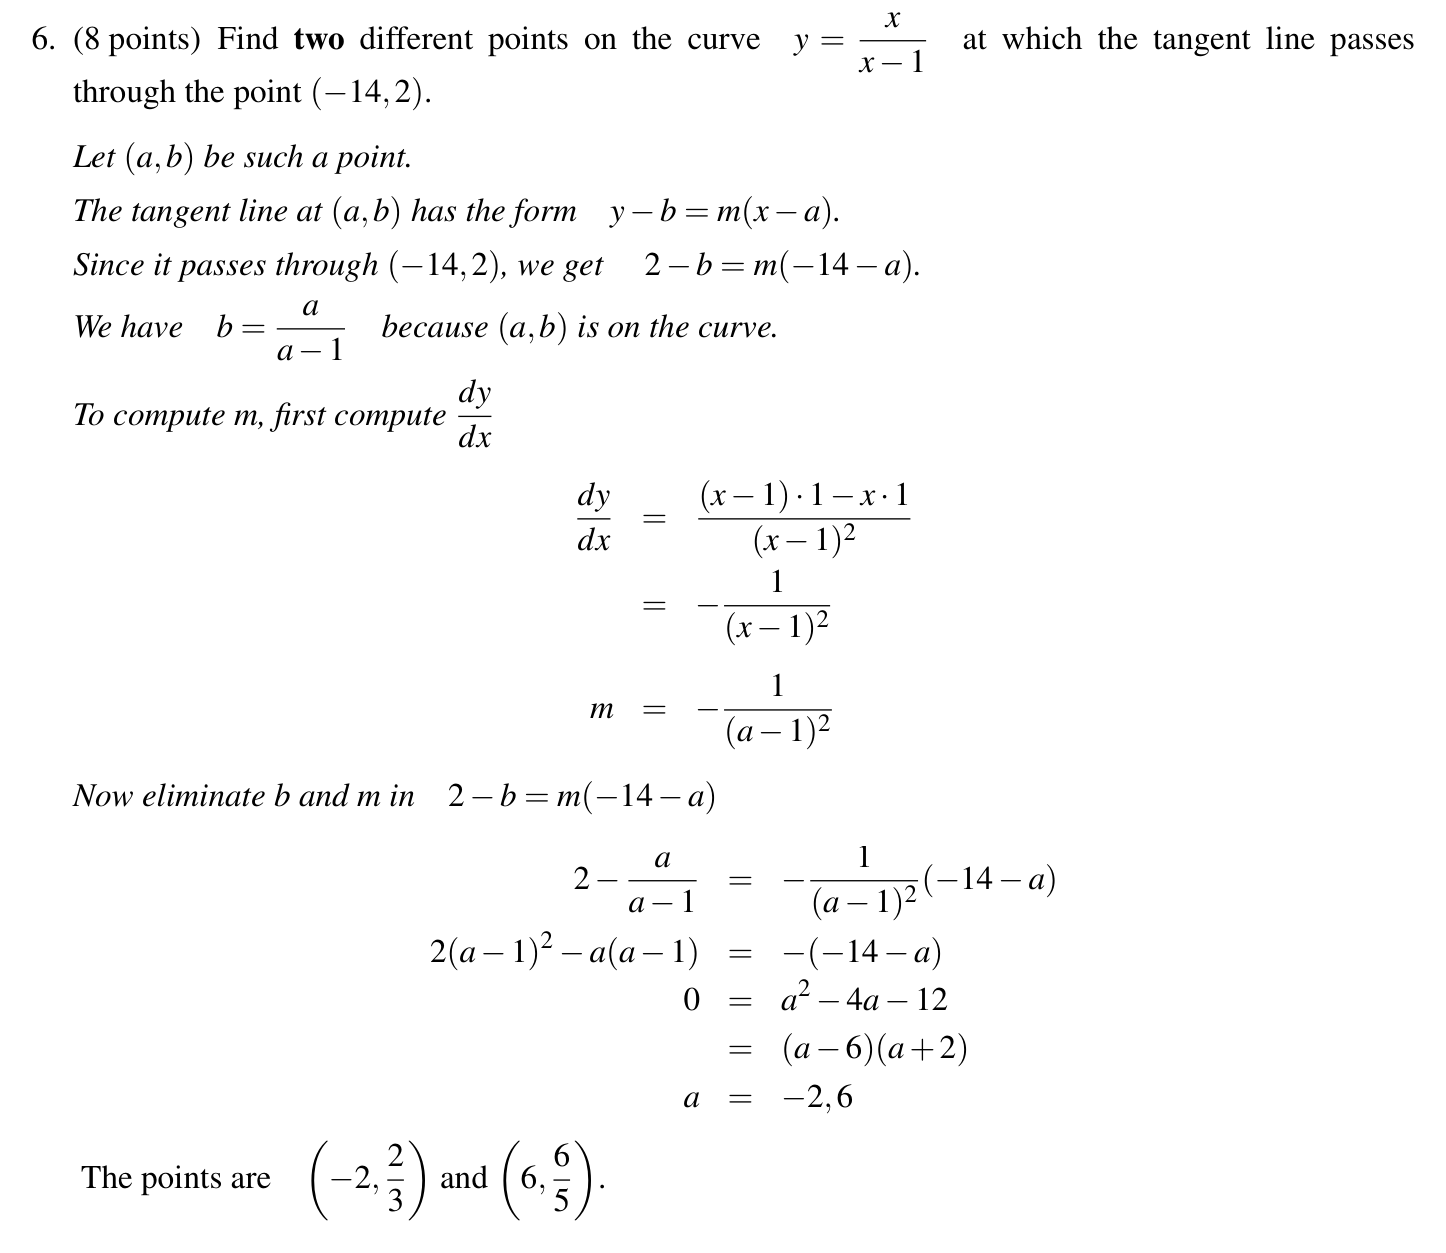

In [80]:
# ▶️ NEXT

ARCHIVE_DIR = Path("../data/archive")
PROCESSED_DIR = Path("../data/processed")

archive_tests = 0
archive_questions = 0
for test_dir_path in ARCHIVE_DIR.iterdir():
    archive_tests += 1
    archive_questions += len(list(test_dir_path.iterdir())) - 1

print(f"Tests in archive: {archive_tests} ({archive_questions} questions)")

def img_tag(p: Path, max_h=220):
    b = p.read_bytes()
    mime = "image/png"
    b64 = base64.b64encode(b).decode("ascii")
    return f'<img src="data:{mime};base64,{b64}" style="max-height:{max_h}px;">'

print(f"Tests left: {len(list(PROCESSED_DIR.iterdir()))}")

for test_path in PROCESSED_DIR.iterdir():
    test_id = test_path.name

    rows = []
    for q_dir in sorted(p for p in test_path.iterdir() if p.is_dir()):
        q = (q_dir / "question.png").resolve()
        a = (q_dir / "answer.png").resolve()

        rows.append(
            f"""
            <tr>
              <td style="padding:8px; vertical-align:top; white-space:nowrap;">{q_dir.name}</td>
              <td style="padding:8px;">{img_tag(q)}</td>
              <td style="padding:8px;">{img_tag(a)}</td>
            </tr>
            """
        )

    html = f"""
    <div>
      <table border="0" cellspacing="0" cellpadding="0">
        <thead>
          <tr>
            <th style="text-align:left; padding:8px;">Q</th>
            <th style="text-align:left; padding:8px;">question.png</th>
            <th style="text-align:left; padding:8px;">answer.png</th>
          </tr>
        </thead>
        <tbody>
          {''.join(rows)}
        </tbody>
      </table>
    </div>
    """
    display(HTML(html))
    break

In [81]:
# 🤖 GENERATE
%run ../scripts/generate_question_metadatas -testId {test_id}

Generating question metadatas for test 9c452e82-81ad-48ca-9b3d-f93193b7d4b9
Q1: ✅
Q2: ✅
Q3: ✅
Q4: ✅
Q5: ✅
Q6: ✅


In [43]:
# ⬜ CAP WHITESPACE

def cap_whitespace_from_canvas(
    canvas: Image,
    max_whitespace_height: int = 32,
    max_whitespace_width: int = 32,
    white_threshold: int = 245,
    min_whitespace_pixels_ratio: float = 0.998,
) -> Image:
    """
    Caps the height and width of whitespace rectangles in a canvas.

    Parameters
    ----------
    canvas: Image
        The original canvas.
    max_whitespace_height: int, optional
        Maximum allowed height (in image pixels) of a whitespace rectangle that is the width of the
        page. Default 32.
    max_whitespace_width: int, optional
        Maximum allowed width (in image pixels) of a whitespace rectangle that is the height of the
        page. Default 32.
    ink_threshold: float, optional
        Minimum value of a grayscale pixel (0-255) to be considered "white". Default 245.
    min_whitespace_pixels_ratio: float, optional
        Minimum ratio of "white" pixels in a row or column to consider the whole row or column
        white.

    Returns
    -------
    canvas: Image
        A new image with capped whitespaces.
    """
    rgb_canvas = canvas.convert("RGB")
    arr_rgb = np.array(rgb_canvas, dtype=np.uint8)

    # --- ROWS ---
    arr_gray = np.array(canvas.convert("L"), dtype=np.uint8)
    arr_height, arr_width = arr_gray.shape

    white_mask = arr_gray >= white_threshold
    row_is_white = white_mask.mean(axis=1) >= min_whitespace_pixels_ratio

    out_rows_rgb = []
    consecutive_whitespace_rows = 0

    for r in range(arr_height):
        if row_is_white[r]:
            if consecutive_whitespace_rows < max_whitespace_height:
                out_rows_rgb.append(arr_rgb[r:r + 1, :, :])

            consecutive_whitespace_rows += 1
        else:
            consecutive_whitespace_rows = 0
            out_rows_rgb.append(arr_rgb[r:r + 1, :, :])

    arr_rgb = np.vstack(out_rows_rgb).astype(np.uint8)

    # --- COLUMNS ---
    arr_gray = np.array(Image.fromarray(arr_rgb).convert("L"), dtype=np.uint8)
    arr_height, arr_width = arr_gray.shape

    white_mask = arr_gray >= white_threshold
    col_is_white = white_mask.mean(axis=0) >= min_whitespace_pixels_ratio

    out_cols_rgb = []
    consecutive_whitespace_cols = 0

    for c in range(arr_width):
        if col_is_white[c]:
            if consecutive_whitespace_cols < max_whitespace_width:
                out_cols_rgb.append(arr_rgb[:, c : c + 1, :])

            consecutive_whitespace_cols += 1
        else:
            consecutive_whitespace_cols = 0
            out_cols_rgb.append(arr_rgb[:, c : c + 1, :])

    arr_rgb = np.concatenate(out_cols_rgb, axis=1).astype(np.uint8)
    return Image.fromarray(arr_rgb)

for question_dir in (Path("../data/processed") / test_id).iterdir():
    if not question_dir.is_dir():
        continue

    for img_path in question_dir.iterdir():
        if img_path.name == "metadata.json":
            continue

        img = cap_whitespace_from_canvas(Image.open(img_path))
        img.save(img_path)

In [79]:
# ✏️ EDIT
os.startfile(test_path.resolve())

In [72]:
# 🗑️ DELETE
shutil.rmtree(test_path)

Common Problems (i.e. not enough cropping):
- What if a question is split across pages and the professor was kind enough to repeat the question/diagram on the second page?
- Long, horizontal lines at the bottom of pages
- Version 2's being attached to last answer
- Need to crop "DO NOT WRITE..."

Common Problems (i.e. wrong or too much cropping)
- What if a non-question page has 1., 2. ...?
- Answer key is not sectioned correctly while questions are! Usually a previous answer contains part of the next one.
- Part of question erased!
- Diagram of a question partially above number